# Create template library and inference pipeline

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
import matplotlib.cm as cm
from scipy.stats import gaussian_kde
import torch

import os

from ili.validation.metrics import PosteriorCoverage
import CASBI.create_template_library as ctl
import CASBI.inference as inference

Create the template libary using the files, dataframe and preprocessing output from the `./preprocessing.ipynb` notebook. In this case we are setting oour observational noise to zero (`sigma = 0.`), and we are training on gpu (`device = 'cuda'`).  

In [ ]:
#path to the files generetated by the CASBI.preprocessing
data_path = "/export/data/vgiusepp/casbi_rewriting"

galaxy_file_path = os.path.join(data_path, "new_files/")
dataframe_path = os.path.join(data_path, "dataframe.parquet")
preprocessing_path = os.path.join(data_path, "preprocess_file.npz")

#generate template library
sigma = 0.
device = 'cuda:6'
template_library = ctl.TemplateLibrary(galaxy_file_path=galaxy_file_path, 
                                       dataframe_path=dataframe_path, 
                                       preprocessing_path=preprocessing_path, 
                                       sigma=sigma,
                                       M_tot=5e10)    
template_library.gen_libary(N_test=100, N_train=1000)



unique galaxy in the test set that are not empty: 100


let's visualize the observation for a given galaxy index `j` and subhalo index `i`.

/tmp/ipykernel_2581313/3067923939.py:10: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(observable.T),


Text(0, 0.5, '[O/Fe]')

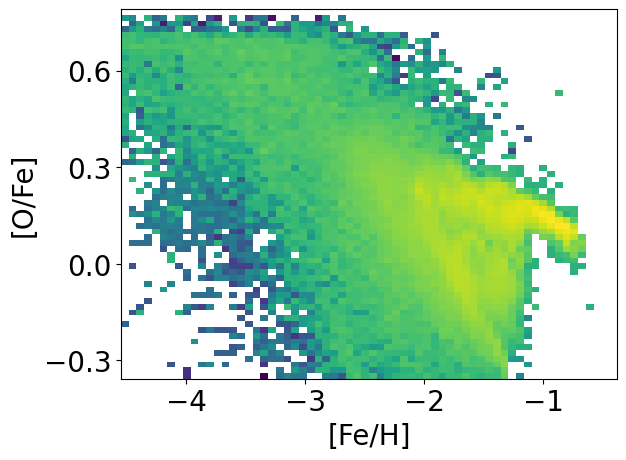

In [3]:
from tkinter import font

# select the i-th and j-th galaxy in the template library for plotting
i=0 #subhalo index in the j-th galaxy
j=0 #galaxy index
observable =  template_library.test_galaxies[(i, j)]['x']


fig, ax = plt.subplots()
ax.imshow(np.log10(observable.T), 
           extent = [template_library.feh_lim[0], template_library.feh_lim[1], template_library.ofe_lim[0], template_library.ofe_lim[1]], 
           origin='lower', 
           cmap='viridis',
           aspect='auto')

# Set the maximum number of ticks on the x and y axes to 4
ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
ax.yaxis.set_major_locator(MaxNLocator(nbins=4))


ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('[Fe/H]', fontsize=20)
ax.set_ylabel('[O/Fe]', fontsize=20)

We can start the inference pipeline by first returning the data in the right format using `template_library.get_inference_input()`, and then by passing it to the `inference.train_inference()` method.

In [4]:
#Inference
x_train, params_train, x_test, params_test = template_library.get_inference_input()

# x_train = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)  # Shape: (batch, 1, 64, 64)
# x_test = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1)  # Shape: (batch, 1, 64, 64)
x_train = torch.tensor(x_train, dtype=torch.float32)  # Shape: (batch, 64, 64)
x_test = torch.tensor(x_test, dtype=torch.float32)  # Shape: (batch, 2)
params_train = torch.tensor(params_train, dtype=torch.float32)  # Shape: (batch, 2)
params_test = torch.tensor(params_test, dtype=torch.float32) # Shape: (batch, 2)

posterior_ensamble, summaries = inference.train_inference(x=x_train, 
                                                          theta=params_train, 
                                                          learning_rate=1e-4, 
                                                          output_dir=f'./posterior/posterior_{sigma}', 
                                                          device=device,
                                                          maximum_theta = [5*1e10, 1.15]
                                                          batch_size=1024*8,)


/tmp/ipykernel_2581313/4261233701.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32)  # Shape: (batch, 64, 64)
/tmp/ipykernel_2581313/4261233701.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float32)  # Shape: (batch, 2)
/tmp/ipykernel_2581313/4261233701.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params_train = torch.tensor(params_train, dtype=torch.float32)  # Shape: (batch, 2)
/tmp/ipykernel_2581313/4261233701.py:9: UserWarning

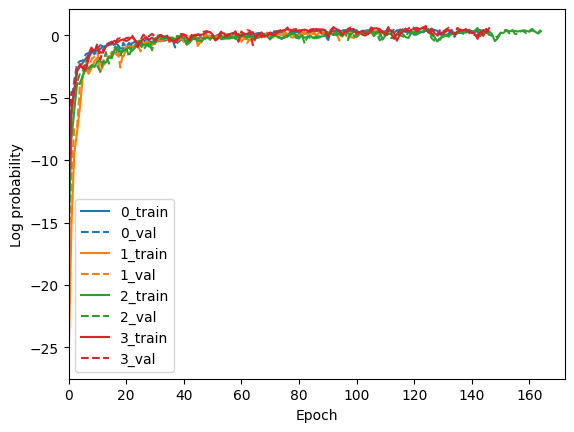

In [5]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, )
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

/tmp/ipykernel_2581313/2831406358.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')  # 'viridis' is the colormap name


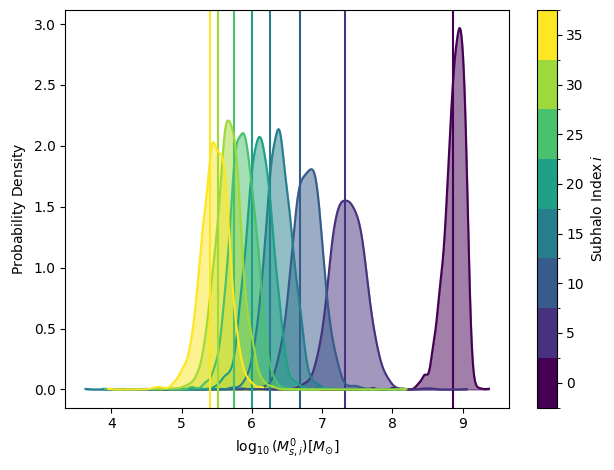

In [6]:
# Plot figure 2 of the paper, model output for the first galaxy (j=0) of the test set

# Create a colormap
cmap = cm.get_cmap('viridis')  # 'viridis' is the colormap name

# Create a list of colors
colors = [cmap(i) for i in np.linspace(0, 1, 8)]  # Replace 8 with the number of colors you want

fig, ax = plt.subplots(1, 1, )
for (c,i) in enumerate(range(40)[::5]):
    mask_obs =  [(x_test[:, 1, 0, 0]==i)&(x_test[:, 2, 0, 0]==0)] #i is the subhalo index, 0 is the galaxy index
    samples = posterior_ensamble.sample((2_000,), x=x_test[mask_obs].to(device), show_progress_bars=False) 
    samples =  samples[:, 0].cpu().numpy()
    density = gaussian_kde(samples)
    density_val = density(np.linspace(min(samples), max(samples), 1000))
    ax.plot(np.linspace(min(samples), max(samples), 1000), density_val, color=colors[c])    
    ax.fill_between(np.linspace(min(samples), max(samples), 1000), density_val, alpha=0.5, color=colors[c])
    
    mask_parameters = [(params_test[:, 2]==i)&(params_test[:, 3]==0)] #i is the subhalo index, 0 is the galaxy index
    ax.axvline(x=params_test[mask_parameters][0, 0].cpu().numpy(), color=colors[c])

ax.set_xlabel(r'$\log_{10}(M_{s,i}^0) [M_{\odot}]$')
ax.set_ylabel(r'$\text{Probability Density}$')

#Colorbar 
norm = mcolors.BoundaryNorm(boundaries=np.arange(-0.5, 8, 1), ncolors=cmap.N)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  

cbar = fig.colorbar(sm, ax=ax, ticks=np.arange(8))
cbar.ax.set_yticklabels([f'{i}' for i in range(8)])  # Set the labels for the colorbar
cbar.set_label(r'$\text{Subhalo Index} \, i$')
fig.tight_layout()

100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


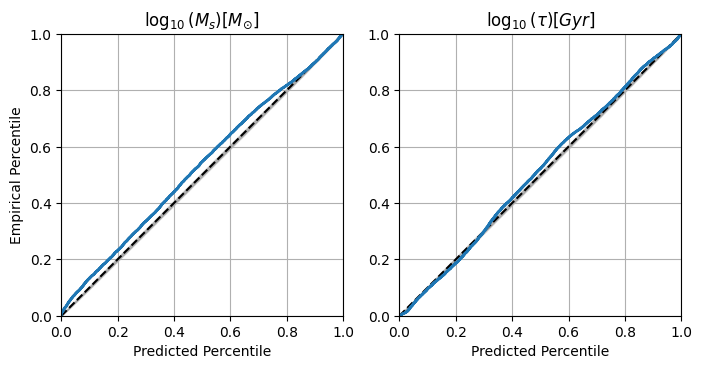

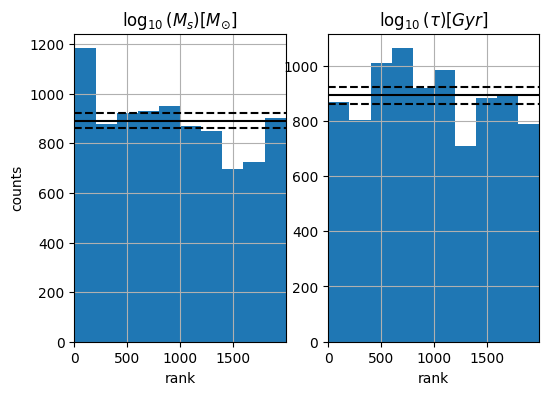

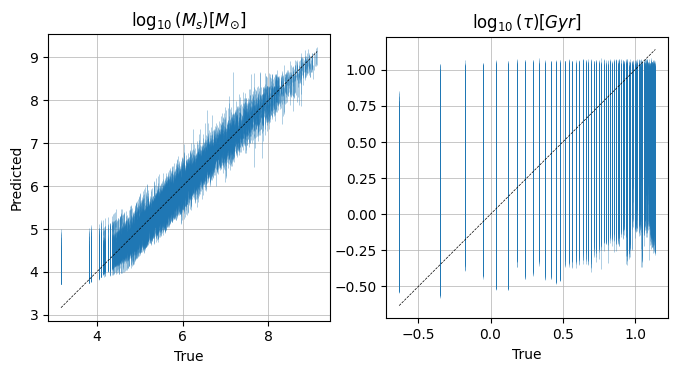

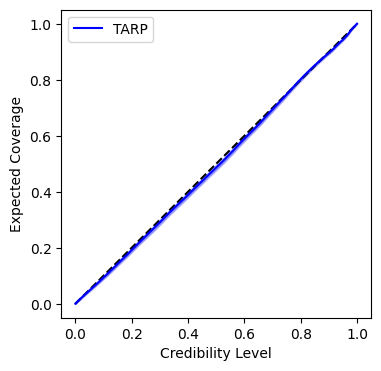

In [7]:
plot_hist = ["coverage", "histogram", "predictions", "tarp"]
metric = PosteriorCoverage(
    num_samples=2_000, sample_method='direct',
    labels=[rf'$\log_{{10}}(M_{{s}}) [M_{{\odot}}]$', rf'$\log_{{10}}(\tau) [Gyr]$'], plot_list = plot_hist
)

fig = metric(
    posterior=posterior_ensamble,
    x=x_test, theta=params_test[:, :2])
